<a href="https://colab.research.google.com/github/giacomo-cgn/cnn-cifar10-adversarial-attacks/blob/main/ISPR_midterm3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Adversarial attacks on CNN for CIFAR10 classification

*Giacomo Cignoni*



1.   Build a simple parametrized CNN with Pytorch
2.   Train the CNN on CIFAR10 dataset and perform a gridsearch on some hyperparameters.

3.    Perform adversarial attacks with Cleverhans





# CNN building

A simple CNN for the CIFAR10 dataset is built with PyTorch. The dataset is imported through PyTorch itself.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import math
from torch.nn import parameter
import numpy as np
import matplotlib.pyplot as plt

The datset is split in mini-batches of small sizes (8 images each) as a small number of element in each batch is more favourable for a CNN for CIFAR, as explained by Masters and Luschi in "Revisiting Small Batch Training for Deep Neural Networks". (https://www.arxiv-vanity.com/papers/1804.07612/#S3)

The dataset is split in 40000 images for training, 10000 for validation in the successive grid search, and another 10000 for the final testing. The split of the development set in validation and training was done manually, but stil preserving the distribution of the classes thanks to the Sklearn function "train_test_split".

Normalization was applied to the dataset in order to obtain better results; the values for normalization of CIFAR10 have been taken from https://github.com/kuangliu/pytorch-cifar/issues/19, as it is a famous dataset and so avoided the their computation.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

batch_size = 8

num_workers = 2

pin_memory = False
if use_cuda:
  pin_memory = True
    
devel_set = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
devel_loader = torch.utils.data.DataLoader(devel_set, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers, pin_memory=pin_memory)


[train_set, val_set] = train_test_split(devel_set, test_size=0.2, stratify=devel_set.targets)


train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

test_set = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cpu


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


A CNN class is defined, with 2-4 convolutional layers, 2-3 fully connected layers, max-pooling and the ability to enable dropout layers between both fully connected and convolutional layers.

The number of features detected in each convolutional layer can be chosen. A small fixed size kernel of size 3x3 with stride 1 was chosen because of the small size of the datset images.

In [ ]:
class CNN(nn.Module):
    def __init__(self, conv_layers_features = [], drop_conv=False, num_fc_layers=2):
        super(CNN, self).__init__()
        self.conv_layers_features = conv_layers_features
        self.drop_conv = drop_conv
        self.conv_arr = nn.ModuleList()
        self.num_fc_layers = num_fc_layers

        input_features = 3
        feature_map_size = 32 # Initial image is 32x32
        for layer_features in self.conv_layers_features:
          self.conv_arr.append(nn.Conv2d(input_features, layer_features, 3))
          input_features = layer_features
          feature_map_size = math.floor((feature_map_size - 2)/2)

        self.pool = nn.MaxPool2d(2, 2)

        if (num_fc_layers == 3):
          self.fc1 = nn.Linear(feature_map_size*feature_map_size*input_features, 1024)
          self.fc2 = nn.Linear(1024, 128)
          self.fc3 = nn.Linear(128, 10)
        else:
          self.fc1 = nn.Linear(feature_map_size*feature_map_size*input_features, 256)
          self.fc2 = nn.Linear(256, 10)

        self.dropout_low = nn.Dropout(0.25)
        self.dropout_high = nn.Dropout(0.5)


    def forward(self, x):
      for conv in self.conv_arr:
        x = conv(x)
        x = F.relu(x)
        x = self.pool(x)
        if self.drop_conv:
          x = self.dropout_low(x)

      if not self.drop_conv:  # Do dropout only at the end of conv layers if dropout not selected
        x = self.dropout_low(x)

      x = torch.flatten(x, 1)

      if (self.num_fc_layers == 3):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_low(x)
        x = self.fc2(x)
        x = self.dropout_low(x)
        x = self.fc3(x)
      else:
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_low(x)
        x = self.fc2(x)
      output = F.log_softmax(x, dim=1)
      return output

This function executes training on the model for 1 epoch

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    criterion = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            

This function executes the predict phase on the model (both for validation and test phases)

In [ ]:
def test(cnn, device, test_loader, is_validation=False):
    cnn.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = cnn(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = correct / len(test_loader.dataset)

    set_name = 'Test'
    if is_validation:
      set_name = 'Validation'

    print('\n'+ set_name +' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * test_acc))
    return test_loss, test_acc


This function defines a simple extensive grid search with testing on separated validation set, in order to find and save the model hyperparameters which gives the best accuracy on the validation data. K-fold cross validation was not executed as too expensive to run.

Adam was chosen as the optimazer for its versatitlity and a fixed number of 10 epochs was chosen after some preliminary trials.

In [ ]:
def grid_search(conv_layers_features_arr, drop_conv_arr, num_fc_layers_arr):
  best_acc = 0
  for conv_layers_features in conv_layers_features_arr:
    for drop_conv in drop_conv_arr:
      for num_fc_layers in num_fc_layers_arr:
        print('HPERPARAMS: conv_layers_features', conv_layers_features, ', drop_conv', drop_conv, ', num_fc_layers', num_fc_layers)


        num_epochs = 10

        cnn = CNN(conv_layers_features=conv_layers_features, drop_conv=drop_conv, num_fc_layers=num_fc_layers).to(device)

        optimizer = optim.Adam(cnn.parameters())

        for epoch in range(num_epochs):
          train(cnn, device, train_loader, optimizer, epoch)
          val_loss, val_acc = test(cnn, device, val_loader, is_validation=True)
          
        if val_acc > best_acc:
          best_acc = val_acc
          best_cnn = cnn
          best_conv_layers_features = conv_layers_features
          best_drop_conv = drop_conv
          num_fc_layers = num_fc_layers
  return best_acc, best_cnn, best_conv_layers_features, best_drop_conv, num_fc_layers

Here the hyperparameters to try in the grid search are defined.

Each element of `conv_layers_features_arr` is an array containing the number of features detected in each convolutional layer in order.

In [ ]:
save_model = True

conv_layers_features_arr = [[32, 128], [32, 128, 512], [32, 256], [64, 128, 512]]
drop_conv_arr = [True, False]
num_fc_layers = [2, 3]

val_acc, cnn, conv_layers_features, drop_conv, num_fc_layers = grid_search(conv_layers_features_arr, drop_conv_arr, num_fc_layers)

if save_model:
    torch.save(cnn.state_dict(), "cifar_cnn.pt")

The best CNN has 3 convolutional layers with  32, 128 and 512 features, has no dropout between the convolutional layers and has 3 fully connected layers at the end. It reaches an accuracy of 72.84% on the validation set

In [ ]:
print(val_acc, conv_layers_features, drop_conv, num_fc_layers)

The found hyperparameters are used to execute a retrain on the whole development set (training + validation sets).

In [ ]:
num_epochs = 10
conv_layers_features = [32, 128, 512]
drop_conv = False
num_fc_layers = 3

cnn = CNN(conv_layers_features=conv_layers_features, drop_conv=drop_conv, num_fc_layers=num_fc_layers).to(device)

optimizer = optim.Adam(cnn.parameters())

for epoch in range(num_epochs):
  train(cnn, device, devel_loader, optimizer, epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.293936
Train Epoch: 0 [8000/50000 (16%)]	Loss: 1.615387
Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.400039
Train Epoch: 0 [24000/50000 (48%)]	Loss: 1.139404
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.277186
Train Epoch: 0 [40000/50000 (80%)]	Loss: 0.937723
Train Epoch: 0 [48000/50000 (96%)]	Loss: 1.121689
Train Epoch: 1 [0/50000 (0%)]	Loss: 1.507894
Train Epoch: 1 [8000/50000 (16%)]	Loss: 1.358314
Train Epoch: 1 [16000/50000 (32%)]	Loss: 0.410676
Train Epoch: 1 [24000/50000 (48%)]	Loss: 0.791027
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.042684
Train Epoch: 1 [40000/50000 (80%)]	Loss: 0.887668
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.412907
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.891843
Train Epoch: 2 [8000/50000 (16%)]	Loss: 1.290987
Train Epoch: 2 [16000/50000 (32%)]	Loss: 0.387417
Train Epoch: 2 [24000/50000 (48%)]	Loss: 1.145666
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.743750
Train Epoch: 2 [40000/50000 (80%)]	Loss: 0.549402
Train Epoch: 2 [48

Test final retrained model on the separated test set. The chosen model reaches a test accuracy of 71.70%.

In [ ]:
test_loss, test_acc = test(cnn, device, test_loader, is_validation=False)



Test set: Average loss: 0.1192, Accuracy: 6858/10000 (69%)



# Adversarial attacks

Let's use Cleverhans library to implement fast gradinet method adversatial attacks to our CNN.

In [ ]:
!pip install cleverhans

     |████████████████████████████████| 92 kB 127 kB/s 
     |████████████████████████████████| 42 kB 834 kB/s 
     |████████████████████████████████| 154 kB 35.4 MB/s 


In [ ]:
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method

Define a new test function which implements fast gradient method. It applies the fast gradient method for our cnn to all test data images (the same datsaset used to assess 71.70% accuracy of the model) and then performs the prediction with the original model.

In [ ]:
def test_adv(cnn, device, test_loader, eps):
    cnn.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss()
    #with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        # Apply fast gradient method
        data_fast_grad = fast_gradient_method(cnn, data, eps, np.inf)
        
        output = cnn(data_fast_grad)
        test_loss += criterion(output, target).item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = correct / len(test_loader.dataset)

    print('\n Test set with adversarial attacks (epsilon = {}): Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        eps, test_loss, correct, len(test_loader.dataset),
        100. * test_acc))
    return test_loss, test_acc

We test variuos values for epsilon, and it is easy to note that the accuracy is decreasing while epsilon is increasing.

In [ ]:
epsilon_arr = [0.0001, 0.01, 0.1, 0.3, 0.5]

for epsilon in epsilon_arr:
    test_adv_loss, test_adv_acc = test_adv(cnn, device, test_loader, eps=epsilon)



 Test set with adversarial attacks (epsilon = 0.0001): Average loss: 0.1191, Accuracy: 6855/10000 (69%)


 Test set with adversarial attacks (epsilon = 0.01): Average loss: 0.1390, Accuracy: 5832/10000 (58%)


 Test set with adversarial attacks (epsilon = 0.1): Average loss: 0.3473, Accuracy: 2267/10000 (23%)


 Test set with adversarial attacks (epsilon = 0.3): Average loss: 0.3760, Accuracy: 1723/10000 (17%)


 Test set with adversarial attacks (epsilon = 0.5): Average loss: 0.3934, Accuracy: 1622/10000 (16%)



Here we show side by side 8 images before and after applying the fast gradient method with epsilon=0.1. The noisy images are not too different from the original ones but as we can see from the predicted labels, they are rarely predicted correctly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

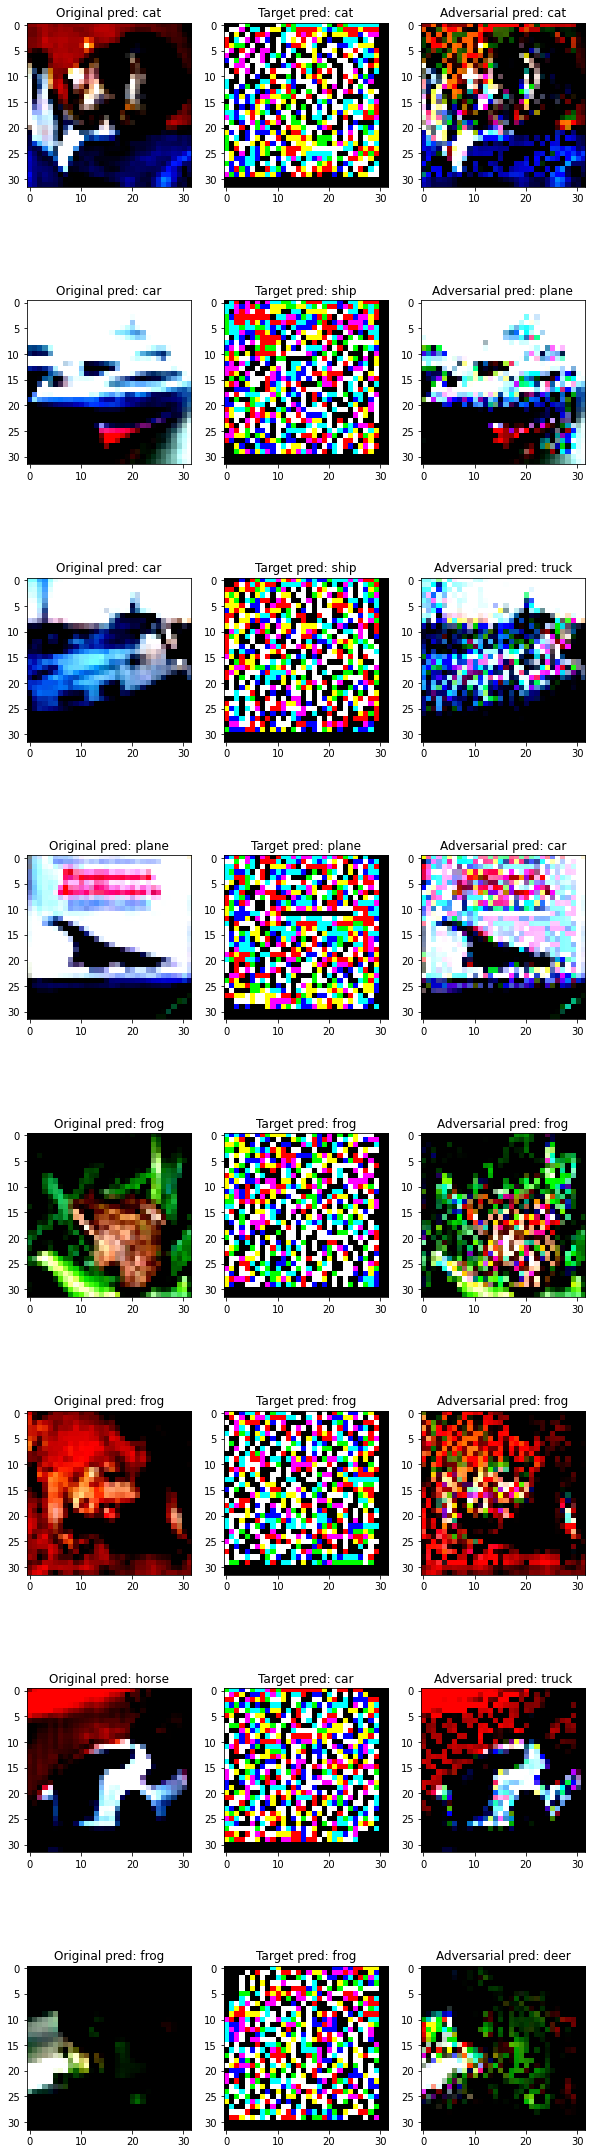

In [ ]:
eps = 0.1
f, set_im = plt.subplots(batch_size,3, figsize=(10,5*(batch_size)))


for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data_fast_grad = fast_gradient_method(cnn, data, epsilon, np.inf) # Apply fast gradient method
        output = cnn(data)
        pred = output.argmax(dim=1, keepdim=True)
        output_adv = cnn(data_fast_grad)
        pred_adv = output_adv.argmax(dim=1, keepdim=True)
        
        for j, pattern in enumerate(data):
            target_class = classes[target[j]]
            pred_calss = classes[pred[j]]
            pred_calss_adv = classes[pred_adv[j]]

            set_im[j][0].set_title('Original pred: ' + pred_calss)
            set_im[j][1].set_title('Target pred: ' + target_class)
            set_im[j][2].set_title('Adversarial pred: ' + pred_calss_adv)

            
            set_im[j][0].imshow(pattern.cpu().detach().permute(1, 2, 0)) # Permute needed to put RGB channel in the end # Permute needed to put RGB channel in the end


            set_im[j][2].imshow(data_fast_grad[j].cpu().detach().permute(1, 2, 0))
            
            # Calculate noise by subtracting the original and modified image and dividing by epsilon
            noise = (pattern.cpu().detach().permute(1, 2, 0).numpy() 
                     - data_fast_grad[j].cpu().detach().permute(1, 2, 0).numpy()) / epsilon
            set_im[j][1].imshow(noise)

        break
plt.show()
